The purpose of this part is to analyse and explore the data to find features that are likely indicators of spam or ham.

Since, the body is the most significant field in an email and has the content that spammers use to exploit thier targets, we generate a word cloud from the body of all spam emails.

### If on Google Colab

In [85]:
!pip install PyDrive

In [86]:
!pip install wordcloud

In [87]:
!pip install xlrd

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!rm -rf structured.xlsx

In [0]:
download = drive.CreateFile({'id': '1oh_fic0-1N1xh4OlTvGMQ5BTKjOmUYKi'})
download.GetContentFile('structured.xlsx')

In [92]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### If not on Google Colab

### Word Cloud

There are certain words that spammers' use very commonly in their email's to catch the attention of their targets. We try to find such words from the email body by constructing a word cloud from our spam dataset. Bigger words in the word cloud are one's that occur more frequently in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import re


Importing the excel file we created in part-1 into a pandas dataframe. We use a converter to convert all empty cell values to np.NaN and non-empty cell values to string type.

In [2]:
# converter
def conv(content):
    '''
    convert datatype to string or np.NaN
    '''
    # check for NaN 
    if(content != content):
        return np.NaN
    # else convert to string
    return str(content)
    

In [3]:
converters = {'Spam':conv, 'Body':conv, 'Subject':conv, 'From':conv, 'To':conv, 'X-UIDL':conv, 'Message-Id':conv, 'Sender':conv}

In [4]:
mails = pd.read_excel('structured.xlsx', index_col=None, converters=converters )

In [5]:
mails.head()

,From,To,Message-Id,Subject,Body,Spam,X-UIDL,Sender
0,aj881c <aj881c@ix.netcom.com>\n,<bagpipes@acadia.net>\n,<19943672.886214@relay.comanche.denmark.eu> M...,2-1\n,email marketing works!!\n\nbull's eye gold is ...,Spam,NaN,NaN
1,iwbp@mailcity.com\n,members@your.net\n,<>\n,"Exclusive Internet Business, 1st Time Offered...",>>>this is the most exciting breakthrough ever...,Spam,NaN,NaN
2,am74rt <am74rt@worldnet.att.net>\n,<badams@eastky.com>\n,<19943672.886214@relay.comanche.denmark.eu> T...,2-17\n,email marketing works!!\n\nbull's eye gold is ...,Spam,NaN,NaN
3,"""D.Reynolds"" <subwiz1@friendlyserver.com>\n",NaN,<199802161222.EAA24869@net1.aoci.com>\n,ADV: FREE DOWNLOAD:Register your web site to ...,free download.register your web site to over 7...,Spam,NaN,NaN
4,carlover@goplay.com\n,carlovers@america.com\n,<>\n,AUTOMOBILE OPPORTUNITY\n,do you love cars?\n\nwant your own business?\n...,Spam,NaN,NaN


To filter out meaningless words and generate a cleaner word cloud, we use the nltk package to: 
1. remove all punctuation using regex & convert to lower case
2. Tokenize, stem (Porter stemmer) & remove stop words

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [7]:
def transformBody(body):
    '''
    data preprocessing steps
    '''
    # removing ' character (eg. dollar's -> dollars)
    # remove other puctuation
    body = str(body).replace("'", "")
    body = re.sub(r"[^\w\s]|_", "", body)
    #body = re.sub("[\s+]", " ", body)

    # to lower case
    bodylower = body.lower()
    
    # tokenize, stem and remove stop words
    bodylist = word_tokenize(bodylower)
    stemmer = PorterStemmer()
    stemmedlist = [stemmer.stem(word) for word in bodylist]
    sw = stopwords.words('english')
    finalist = [word for word in bodylist if(word not in sw)]
    return finalist

Filtering out body column for spam rows 

In [8]:
spamBodies = mails[mails['Spam'] == 'Spam']['Body']

Preprocess spam body

In [9]:
spamBodies2 = spamBodies.map(transformBody)

Aggregating all spam rows to generate wordcloud

In [10]:
spam_words = ' '.join(np.concatenate(spamBodies2.values.tolist()).tolist())

Using wordcloud package to generate the wordcloud.

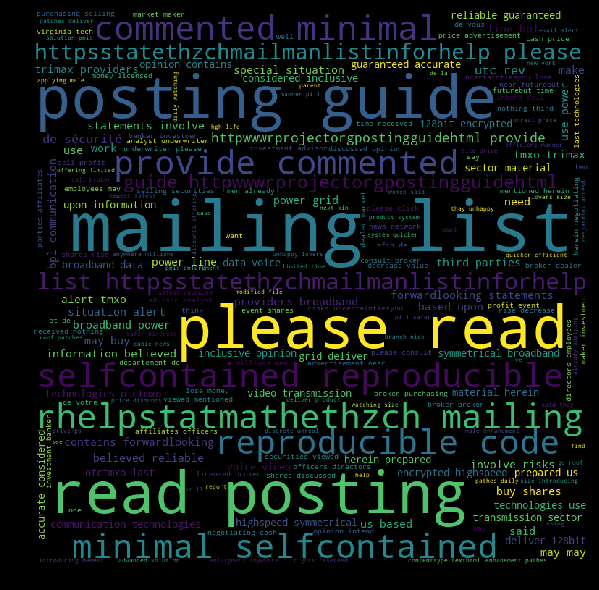

In [11]:
spam_wc = wordcloud.WordCloud(width=768, height=768).generate(spam_words)
plt.figure(figsize=(10,8), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### Wordcloud inference:

Words like mailing, list, retail, price, per, item, posting are frequently found in spam emails. They indicate that the spammer wants to sell an item or send spams after user is subscribed to a mailing list or job posting.

In [12]:
#spamBodies['whereHTML'] = spamBodies['Body'].apply(lambda x: x[x.find('tm3')-30:] if(str(x).find('tm3') != -1) else np.NaN)

In [13]:
#spamBodies[spamBodies['whereHTML'].notna()]['whereHTML']

In [14]:
#print(spamBodies.ix[41]['Body'])

## Engineering features from Email Headers

Email headers show the route an email has taken before arriving at its recipient. It contains important information like sender, recipient, message-id, date and time, subject etc. 

There are two reasons why spammers try to malform email headers.<br/>
    1.They try to conceil their identity and real source of the email.<br/>
    2.They try to conceil the fact that the email was part of a mass mailing effort.

FEATURE1: Spammers will sometimes enter all recipients in the Bcc field, and the address in the 'From' field is used in the 'To' field. Creating a new column 'Feature1' where 1 indicates 'From' field is the same as 'To' field, 0 indicates otherwise.

In [15]:
df_final = mails

In [16]:
# Feature1 -> From same as To. If yes -> 1, else 0
df_final['Feature1'] = 0
df_final.loc[df_final['From'] == df_final['To'], 'Feature1'] = 1
df_final['Feature1'].describe()

count    5039.000000
mean        0.001985
std         0.044508
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Feature1, dtype: float64

FEATURE2: Again, because spammers send out emails by filling the 'Bcc' field, they sometimes leave the 'To' field empty or with an invalid string. Creating a new column 'Feature2' where 1 indicates invalid or NaN 'To' field, 0 indicates otherwise.

The method defined below splits the passed string around the ',' character, to get individual email addresses, 
which are stripped off of the new line chars. Method can handle email address strings like 
`"Tomas Jacobs" <RickyAmes@aol.com>` also. Regex is then used to check format correctness

In [17]:
import re
def isValidEmailFormat(emails):
    '''
    regex to check valid email addresses where 0 is valid and 1 is invalid
    '''
    for email in str(emails).split(','):
        if(email.isspace() or len(email) == 0):
            continue
            
        email = re.sub(r'(\n+)', r' ', str(email)).strip()
        #print(email)
        
        if(re.match(r"(.+)<(.+)>|<(.+)>", email)):
            email = email[email.find("<")+1:-1]
            #print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                #print('continue')
                continue
            else:
                #print('1')
                return 1
        else:
            return 1
        
    return 0

In [18]:
# Feature2 -> is the To column na or invalid ? 1->invalid, 0->valid
df_final['Feature2'] = 0
df_final['Feature2'] = df_final['To'].map(isValidEmailFormat)
df_final.loc[df_final['To'].isna(),'Feature2'] = 1
df_final[df_final['Feature2'] == 1][['Feature2','To']].head()

,Feature2,To
3,1,NaN
18,1,bguenter@gemprint.com \n\n Is your site l...
19,1,bruce.guenter@gemprint.com \n\n Is your s...
20,1,bguenter@linus.vsource.com \n\n Is your s...
108,1,"Kuhn, Max\n"


FEATURE3: Since the 'Message-Id' contains information about where the email is coming from, in spam mails, it is typically missing or malformed. Message-Ids are of the form xxx@domain.com. The method below checks the correctness of the Message-Id format. Creating a new column 'Feature3' where 1 indicates Message-ID malformed or missing, 0 indicates otherwise. 

In [19]:
import re
def isValidMessageID(mid):
    '''
    checks for valid domain in message id where 0 is valid and 1 is invalid
    '''
    for email in str(mid).split('\n'):
        if(email.isspace() or len(email) == 0 or email.find('@') < 0):
            continue
            
        email = email.strip()
        #print(email)
        
        if(re.match(r"(.+)?<<(.+)@(.+)>>(.+)?", email)):
            email = email[email.find("<<")+1:email.rfind(">>")]
            #print(0, email)
        
        if(re.match(r"(.+)?<(.+)@(.+)>(.+)?", email)):
            email = email[email.find("<")+1:email.rfind(">")]
            #print(0, email)
            
        if(len(email) > 7):
            if(re.match("^.+@([?)[a-zA-Z0-9-.]+.([a-zA-Z]{2,3}|[0-9]{1,3})(]?))$", email) != None):
                return 0
            else:
                continue
        else:
            continue
        
    return 1

Displaying Message-Id values that are malformed.

In [20]:
# Feature3 -> is the Message-Id column na or invalid ? 1->invalid, 0->valid
df_final['Feature3'] = 0
df_final['Feature3'] = df_final['Message-Id'].map(isValidMessageID)
df_final.loc[df_final['Message-Id'].isna(),'Feature3'] = 1
df_final.loc[df_final['Feature3'] == 1][['Feature3','Message-Id']].head()

,Feature3,Message-Id
1,1,<>\n
4,1,<>\n
5,1,Mach10 1.1 fxpromo.com\n
10,1,<199803250408.UAA03361>\n
13,1,NaN


FEATURE4: The 'X-UIDL' header is intended to stop the recepient's mail server from downloading multiple copies of the mail once the mail is received. Normally, X-UIDL is stripped once the mail is received. Spammers' intentionally add the X-UIDL, so that mail servers download multiple copies of the mail, increasing chances of it being read. Creating a new column 'Feature4', where 1 indicates X-UIDL not empty, 0 indicates otherwise.

Displaying rows where X-UIDL is not empty.

In [21]:
# Feature4, is the X-UIDL header not empty or na ? 1->not empty, 0->empty 
df_final['Feature4'] = 0
df_final.loc[df_final['X-UIDL'].notna(), 'Feature4'] = 1
df_final.loc[df_final['X-UIDL'].isna(), 'Feature4'] = 0
df_final.loc[df_final['Feature4']==1]['X-UIDL'].head()

9      c89dd4e061ba173523703cf25c3133a2\n
11     763cf6e5123c1287a83f12d7e99c60c9\n
16                  10293287_192832.222\n
22     f2c3e4bf7654f32bfd17a6c54dc32f1d\n
24     11111111111111111111111111111111\n
Name: X-UIDL, dtype: object

Count analysis for feature 1

In [22]:
s = df_final[df_final['Spam'] == 'Ham']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a Different From and To', s0.count())
ham_feature1 = s1.count()
print('Count of Ham emails that have a Same From and To', ham_feature1)

s = df_final[df_final['Spam'] == 'Spam']['Feature1']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have a Different From and To', s0.count())
spam_feature1 = s1.count()
print('Count of Spam emails that have a Same From and To', spam_feature1)

Count of Ham emails that have a Different From and To 1394
Count of Ham emails that have a Same From and To 2
Count of Spam emails that have a Different From and To 3635
Count of Spam emails that have a Same From and To 8


Count analysis for feature 2

In [23]:
s = df_final[df_final['Spam'] == 'Ham']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a valid To field', s0.count())
ham_feature2 = s1.count()
print('Count of Ham emails that have an inValid To field', ham_feature2)

s = df_final[df_final['Spam'] == 'Spam']['Feature2']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of spam emails that have a valid To field', s0.count())
spam_feature2 = s1.count()
print('Count of spam emails that have an inValid To field', spam_feature2)

Count of Ham emails that have a valid To field 1339
Count of Ham emails that have an inValid To field 57
Count of spam emails that have a valid To field 3519
Count of spam emails that have an inValid To field 124


Count analysis for feature 3

In [24]:
s = df_final[df_final['Spam'] == 'Ham']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have a Valid Message-Id field', s0.count())
ham_feature3 = s1.count()
print('Count of Ham emails that have an InValid Message-Id field', ham_feature3)

s = df_final[df_final['Spam'] == 'Spam']['Feature3']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have a Valid Message-Id field', s0.count())
spam_feature3 = s1.count()
print('Count of Spam emails that have an InValid Message-Id field', spam_feature3)

Count of Ham emails that have a Valid Message-Id field 1335
Count of Ham emails that have an InValid Message-Id field 61
Count of Spam emails that have a Valid Message-Id field 3461
Count of Spam emails that have an InValid Message-Id field 182


Count analysis for feature 4

In [25]:
s = df_final[df_final['Spam'] == 'Ham']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Ham emails that have an empty X-UIDL field', s0.count())
ham_feature4 = s1.count()
print('Count of Ham emails that do not have an empty X-UIDL field', ham_feature4)

s = df_final[df_final['Spam'] == 'Spam']['Feature4']
s0 = s[s == 0]
s1 = s[s == 1]
print('Count of Spam emails that have an empty X-UIDL field', s0.count())
spam_feature4 = s1.count()
print('Count of Spam emails that do not have an empty X-UIDL field', spam_feature4)

Count of Ham emails that have an empty X-UIDL field 1396
Count of Ham emails that do not have an empty X-UIDL field 0
Count of Spam emails that have an empty X-UIDL field 3632
Count of Spam emails that do not have an empty X-UIDL field 11


x_data indicates number of bars in the chart displayed below later <br>
y_data is a numpy array of counts of all features calculated above <br>
y_sum is sum of spam and ham for y

In [26]:
x_data = (1,2,3,4)
y_data = np.array([[spam_feature1,spam_feature2,spam_feature3,spam_feature4],[ham_feature1,ham_feature2,ham_feature3,ham_feature4]])
y_sum = y_data[0]+y_data[1]


## Plot data

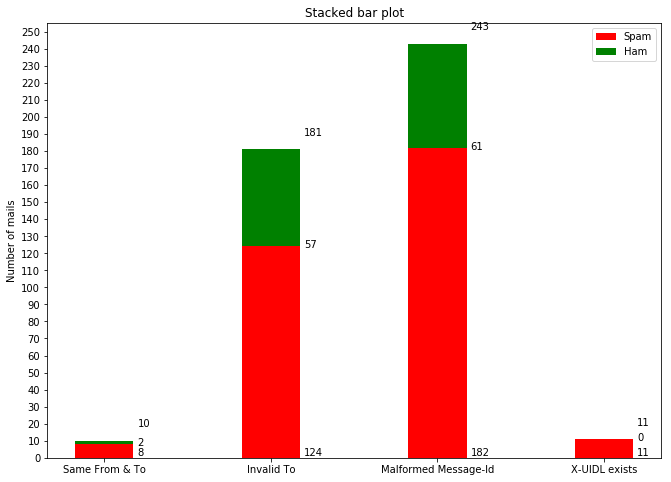

In [27]:
p1 = plt.bar(x_data,y_data[0],color='r',align='center',label=['f1','f2','f3','f4'], width=0.35)
p2 = plt.bar(x_data,y_data[1],color='g',bottom=y_data[0],align='center',label=['f1','f2','f3','f4'], width=0.35)
plt.ylabel('Number of mails')
plt.title('Stacked bar plot')
plt.xticks(x_data, ('Same From & To','Invalid To','Malformed Message-Id','X-UIDL exists'))
plt.yticks(np.arange(0,np.max(y_sum)+10,10))
plt.legend((p1[0],p2[0]),('Spam','Ham'),loc = 'upper right')

plt.text(1.20,1,spam_feature1)
plt.text(1.20,spam_feature1-1,ham_feature1)
plt.text(1.20,spam_feature1+ham_feature1+8,y_sum[0])

plt.text(2.20,1,spam_feature2)
plt.text(2.20,spam_feature2-1,ham_feature2)
plt.text(2.20,spam_feature2+ham_feature2+8,y_sum[1])

plt.text(3.20,1,spam_feature3)
plt.text(3.20,spam_feature3-1,ham_feature3)
plt.text(3.20,spam_feature3+ham_feature3+8,y_sum[2])

plt.text(4.20,1,spam_feature4)
plt.text(4.20,spam_feature4-1,ham_feature4)
plt.text(4.20,spam_feature4+ham_feature4+8,y_sum[3])

fig = plt.gcf()
fig.set_size_inches(11,8)
plt.show()

### Plot Inference

The above chart depicts our 4 email header features on the x-axis. Notice that the red bars (spam) are longer than the green (ham). This indicates that spam emails are more likely to exhibit these 4 features than ham emails.   

Also, 'Same From & To' & 'X-UIDL exists' do indicate spam, but they are weak indicators of spam mail. (Because it is possible that you may want to send an email to yourself) 